In [13]:
import math
from termcolor import colored
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.pyplot as plt
from prepare_data import get_data
from sklearn.model_selection import train_test_split

In [14]:
def get_dataset(train_data):
    """ Fills len(train_data) long arrays with 60 records 
        in each position
        example = [[1...60], [1...60], ...]
    """
    x_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, :-1])
    return np.array(x_train)

In [15]:
def create_model(shape_examples, shape_features):
    print(colored('Generating LSTM model.', 'yellow'))
    print(colored(f'Shape {shape_examples}x{shape_features}', 'cyan'))

    model = Sequential()
    model.add(LSTM(
        units=50,
        return_sequences=True,
        input_shape=(shape_examples, shape_features)
    ))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(units=50))
    model.add(Dropout(0.25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [16]:
try:
    df = pd.read_csv("resources/test.csv")
except FileNotFoundError:
    print(colored('Creating missing file.', 'red'))
    get_data()
    df = pd.read_csv("resources/test.csv")
df = df.iloc[:, 2:]
df[55:65]

,High,Open,Close,Low,AO_1_500,SMA_500,RSI_14,ATRr_14,STDEV_30,prediction
55,3082.9,3077.6,3071.2,3061.3,361.9362,2711.3092,64.886813,26.227139,70.245829,3088.2
56,3098.9,3071.1,3088.2,3070.2,372.6779,2713.0380,68.575561,26.403772,66.495965,3095.4
57,3109.4,3087.9,3095.4,3083.7,382.9923,2714.6882,70.012433,26.353502,63.961167,3120.7
58,3127.9,3095.7,3120.7,3094.4,395.8851,2716.4402,74.435823,26.863966,62.820996,3141.8
59,3142.3,3120.8,3141.8,3116.9,412.5848,2718.1824,77.426439,26.759397,61.959707,3138.4
60,3139.9,3138.9,3138.4,3136.8,419.6071,2719.8960,75.885905,25.205155,59.913741,3135.4
61,3143.7,3138.2,3135.4,3131.7,417.2483,2721.6002,74.477798,24.261929,57.994641,3119.9
62,3142.9,3135.7,3119.9,3109.9,404.2736,2723.2684,67.507932,24.886077,54.412845,3119.0
63,3122.9,3120.1,3119.0,3094.4,384.8622,2724.9696,67.115184,25.144215,51.075969,3129.4
64,3137.0,3119.1,3129.4,3109.5,397.7627,2726.6616,69.335289,25.312485,49.252052,3115.6


In [17]:
try:
    X = np.load('resources/X.npy')
    Y = np.load('resources/Y.npy')
    scaler = joblib.load("resources/scaler.save")
    print(colored('Loaded storaged data.', 'green'))
except FileNotFoundError:
    print(colored('Setting up parameters.', 'yellow'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)  # shape (70718, 8)
    joblib.dump(scaler, "resources/scaler.save")
    X = get_dataset(scaled_data)
    Y = np.array(scaled_data[60:len(scaled_data), -1])
    np.save("resources/X.npy", X)
    np.save("resources/Y.npy", Y)
    print(colored('Parameters saved succesfully.', 'green'))


Loaded storaged data.


In [18]:
print(colored(f'X shape: {X.shape}', 'yellow'))
print(colored(f'Y shape: {Y.shape}', 'yellow'))

training_data_len = math.ceil(len(Y) * .75)
x_train = X[:training_data_len]
y_train = Y[:training_data_len]
x_train = np.array(x_train)
y_train = np.array(y_train)

print(colored(f'X_train shape: {x_train.shape}', 'blue'))
print(colored(f'Y_train shape: {y_train.shape}', 'blue'))

x_test = X[training_data_len:-1]
y_test = Y[training_data_len:-1]
x_test = np.array(x_test)
y_test = np.array(y_test)

print(colored(f'X_test shape: {x_test.shape}', 'red'))
print(colored(f'Y_test shape: {y_test.shape}', 'red'))

print("-"*10)
print('test + train:', colored(
    y_test.shape[0] + y_train.shape[0],
    'green' if y_test.shape[0] + y_train.shape[0] == (Y.shape[0] - 1) else 'red'
))


X shape: (70190, 60, 9)
Y shape: (70190,)
X_train shape: (52643, 60, 9)
Y_train shape: (52643,)
X_test shape: (17546, 60, 9)
Y_test shape: (17546,)
----------
test + train: 70189


In [7]:
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(
    X, Y, test_size=0.33, random_state=42)
print(colored(f'X_train_ shape: {X_train_.shape}', 'blue'))
print(colored(f'Y_train_ shape: {Y_train_.shape}', 'blue'))
print(colored(f'X_test_ shape: {X_test_.shape}', 'red'))
print(colored(f'Y_test_ shape: {Y_test_.shape}', 'red'))

X_train_ shape: (47027, 60, 9)
Y_train_ shape: (47027,)
X_test_ shape: (23163, 60, 9)
Y_test_ shape: (23163,)


In [19]:
train_data = ["sequential", "random"]
for data_type in train_data:
    try:
        model = load_model(f'resources/my_model_{data_type}.h5')
        print(colored('Model loaded successfully', 'green'))
    except IOError:
        print(colored('Training...', 'yellow'))
        model = create_model(X.shape[1], X.shape[-1])
        if data_type == "sequential":
            history = model.fit(
                x_train, y_train, batch_size=256, epochs=100,
                validation_data=(x_test, y_test)
            )
        else:
            history = model.fit(
                X_train_, Y_train_, batch_size=256, epochs=100,
                validation_data=(X_test_, Y_test_)
            )
        model.save(f'resources/my_model_{data_type}.h5')
        hist_df = pd.DataFrame(history.history)
        with open(f'resources/history_{data_type}.csv', mode='w') as f:
            hist_df.to_csv(f)


Model loaded successfully
Model loaded successfully


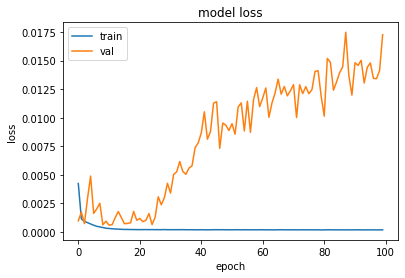

In [20]:
history = pd.read_csv("resources/history_sequential.csv")
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
train_acc = model.evaluate(x_train, y_train, verbose=0)
train_acc

2022-07-28 09:41:33.809779: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 113708880 exceeds 10% of free system memory.


4.5706685341428965e-05

In [22]:
# index = 2
# sample = np.array([x_train[index]])

# y_sample = scaler.inverse_transform([[y_train[index]] * 7 + [y_train[index]]])
# print(y_sample[0][-1])
# prediction = model.predict(sample)[0][0]
# data = scaler.inverse_transform([[prediction] * 7 + [prediction]])
# print(data[0][-1])
# # print("train: ", mean_squared_error(y_train, prediction))


ValueError: operands could not be broadcast together with shapes (1,8) (10,) (1,8) 